### Midas

Código provindo em partes do tutorial https://pytorch.org/hub/intelisl_midas_v2/

In [1]:
import cv2
import torch
import numpy as np
import time
import os, glob, re, json
import matplotlib.pyplot as plt
from typing import List, Tuple

def load_models(model_type: str):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    return midas, transform, device

# RODE APENAS UMA VEZ. SE RODAR MAIS DE UMA, ESTOURA MEMORIA POR CARREGAR O MODELO DE NOVO
midas_s, transform_s, device = load_models("MiDaS_small")
midas_h, transform_h, device = load_models("DPT_Hybrid")

Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /home/admi/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_Mi

In [2]:
THRESHOLDS = [0.2, 0.5] # Duas divisoes para 3 niveis de profundidade (longe, medio, perto)

def carregar_imagem(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[aviso] não consegui abrir: {path}")
    return img

def _regex_tail_number(s: str) -> int:
    """
    Extrai um número "útil" do fim do nome para ordenação. 
    Se não encontrar, tenta qualquer número em s; se ainda não, retorna 0.
    """
    base = os.path.basename(s)
    m = re.search(r'(\d+)(?=\D*$)', base)  # último bloco numérico antes do fim
    if m: return int(m.group(1))
    m2 = re.search(r'(\d+)', base)
    return int(m2.group(1)) if m2 else 0

def ordenar_arquivos_imagem(caminho_pasta: str) -> List[str]:
    padroes = ['*.jpg','*.jpeg','*.png','*.bmp','*.tif','*.tiff','*.webp']
    arquivos = []
    for p in padroes:
        arquivos.extend(glob.glob(os.path.join(caminho_pasta, p)))
    arquivos = list(set(arquivos))  # evita duplicados por padrões sobrepostos
    if not arquivos:
        return []
    arquivos.sort(key=lambda f: (_regex_tail_number(f), os.path.basename(f).lower()))
    return arquivos

def get_imgs(caminho_pasta):
    img_list = []

    raiz_resultados = os.path.join(
        "resultados_etapa2", os.path.basename(os.path.normpath(caminho_pasta)))
    os.makedirs(raiz_resultados, exist_ok=True)

    arquivos_de_imagem = ordenar_arquivos_imagem(caminho_pasta)
    if len(arquivos_de_imagem) < 1:
        print("Erro: É necessária pelo menos 1 imagem na pasta.")
        return
    for i, caminho in enumerate(arquivos_de_imagem):
        img = carregar_imagem(caminho)
        if img is not None:
            img_list.append(img)
    return img_list

def get_depth(midas, transform, device, path):
    output_list = []
    img_list = get_imgs(path)
    if not img_list:
        return None
    for img in img_list:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        input_batch = transform(img).to(device)

        with torch.no_grad():
            start_time = time.time()
            prediction = midas(input_batch)
            end_time = time.time()
            print(f"Inference time: {end_time - start_time:.4f} seconds")


            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        output = prediction.cpu().numpy()

        output = (output - output.min()) / (output.max() - output.min())
        output_list.append(output)

    return output_list

def thresholds_depth(depth_map: np.ndarray):
    t1, t2 = THRESHOLDS  # quanto maior o valor, mais perto da camera
    result = np.zeros_like(depth_map)  # Start with all zeros
    result[(depth_map >= t1) & (depth_map < t2)] = 1  # Middle threshold
    result[depth_map >= t2] = 2  # Closest threshold
    return result

def show_images(*images):
    n = len(images)
    for i in range(n):
        plt.figure()
        plt.title(f"Img {i + 1}")
        plt.imshow(images[i], cmap='viridis')
        plt.colorbar(label="Depth Value")
        plt.axis('off')
    plt.show()

Inference time: 0.1754 seconds
Inference time: 0.5870 seconds
Inference time: 0.5870 seconds


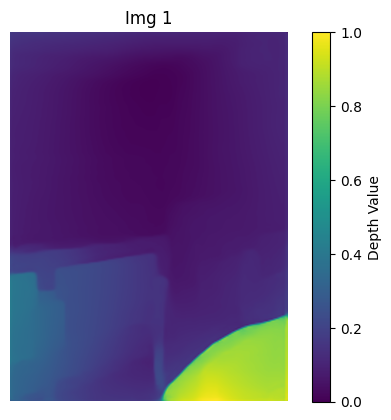

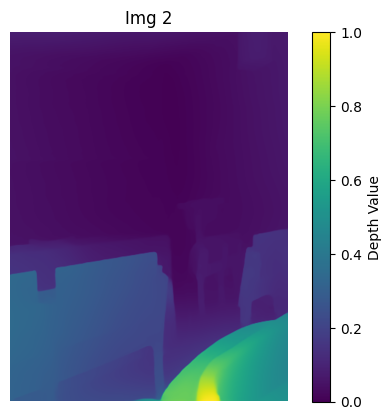

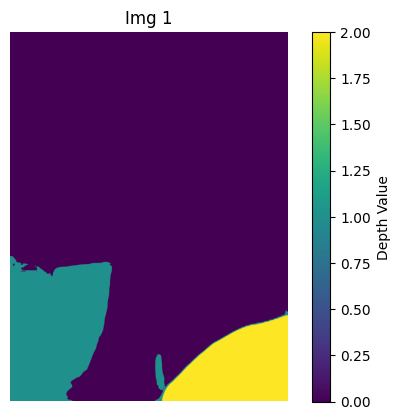

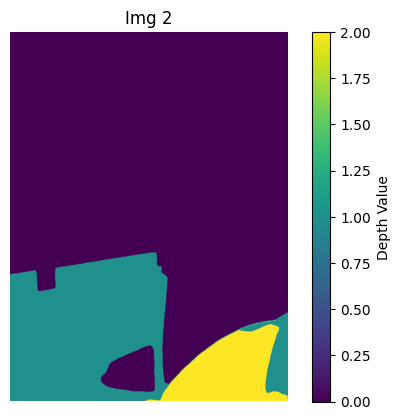

In [3]:
path = "imagens-t3/"
img1 = get_depth(midas_s, transform_s, device, path)  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
img2 = get_depth(midas_h, transform_h, device, path)  # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
if img1 is None or img2 is None:
    print("Nenhuma imagem foi carregada. Verifique o caminho fornecido.")
    exit()
for i in range(len(img1)):
    show_images(img1[i], img2[i])

for i in range(len(img1)):
    img1[i] = thresholds_depth(img1[i])
    img2[i] = thresholds_depth(img2[i])
    show_images(img1[i], img2[i])
